## Mini-Capstone Project:

  ### Whale Activity vs. Price Movement, combining Coingecko and Dune Sim API data:

### Project Title: “Do Whales Move the Market?” — Analyzing Large Transfers vs Price Movements

  #### Project Goal:
    Analyze whether spikes in whale activity (large transfers) precede or correlate with significant price movements of a selected token.

    Core Components:
    Data Source
    Purpose
    Coingecko API
    Daily/hourly price data
    Dune Sim API
    Whale transactions (>$100K)
    Pandas, Matplotlib
    Data wrangling and visualization


    Skills Covered
    REST API requests (requests)


    JSON parsing


    Pandas DataFrame operations (merge, groupby, fillna)


    Time-series analysis


    Dual-axis plotting in Matplotlib and Seaborn


    Logic building and insight generation


### Setup

### Retrieving Data for Whale Transfers of $UNI on Ethereum Chain in the last 90Days

In [109]:
import os, requests, time
from dotenv import load_dotenv

load_dotenv()
api_key = os.getenv("DUNE_API_KEY")

headers = {"X-Dune-Api-Key": api_key}

QUERY_ID = 5634365  # example query id from Dune

# Step 1: Execute the query
res = requests.post(f"https://api.dune.com/api/v1/query/{QUERY_ID}/execute", headers=headers)
print("Execute:", res.json())
execution_id = res.json().get("execution_id")

# Step 2: Poll results until ready
while True:
    r = requests.get(f"https://api.dune.com/api/v1/execution/{execution_id}/results", headers=headers)
    data = r.json()
    if "result" in data and "rows" in data["result"]:
        print("Got results:", data["result"]["rows"][:3])  # print first 3 rows
        break
    print("Waiting...")
    time.sleep(3)


Execute: {'execution_id': '01K2PXAC5SGXD0HV6954GEAZD5', 'state': 'QUERY_STATE_PENDING'}
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
Got results: [{'amount': 21341, 'amount_usd': 124155.36415061424, 'block_time': '2025-05-17 13:15:35.000 UTC', 'contract_address': '0x1f9840a85d5af5bf1d1762f925bdaddc4201f984', 'from': '0xf8191d98ae98d2f7abdfb63a9b0b812b93c873aa', 'symbol': 'UNI', 'to': '0xeae7380dd4cef6fbd1144f49e4d1e6964258a4f4', 'tx_hash': '0x198635ff46b66e9319ee9c5ce53b95fcf0547c7645083790f570f53b558852f2'}, {'amount': 415259.78362153895, 'amount_usd': 2415853.50511398, 'block_time': '2025-05-17 13:15:47.000 UTC', 'contract_address': '0x1f9840a85d5af5bf1d1762f925bdaddc4201f984', 'from': '0x1d733e9e626a7c53ff2a94e2982a0a2212948378', 'symbol': 'UNI', 'to': '0xcd531ae9efcce479654c4926dec5f6209531ca7b', 'tx_hash': '0x5414aaab8eeff95c2ca179e8615f6640c26c4cc28923bade1736a8ac4102eaac'}, {'amount': 415259.78362153895, 'amount_usd': 2415853.50511398, 'block_time': '2025-05

In [110]:
type(data) # Confirming the type of data returned

dict

In [111]:
data.keys() # Checking the keys in the data dictionary

dict_keys(['execution_id', 'query_id', 'is_execution_finished', 'state', 'submitted_at', 'expires_at', 'execution_started_at', 'execution_ended_at', 'result'])

In [112]:
data["result"]["rows"][0].keys() # Checking the keys in the first row of results

dict_keys(['amount', 'amount_usd', 'block_time', 'contract_address', 'from', 'symbol', 'to', 'tx_hash'])

In [113]:
# Converting results to DataFrame
import pandas as pd 

rows = data["result"]["rows"]   # this is a list of dicts
df = pd.DataFrame(rows)

pd.set_option("display.float_format", "{:,.2f}".format)

print(df.head())


print(df.head())
print(df.dtypes)   # check column types


      amount   amount_usd                   block_time  \
0  21,341.00   124,155.36  2025-05-17 13:15:35.000 UTC   
1 415,259.78 2,415,853.51  2025-05-17 13:15:47.000 UTC   
2 415,259.78 2,415,853.51  2025-05-17 13:15:47.000 UTC   
3 624,200.00 3,631,403.32  2025-05-17 13:16:11.000 UTC   
4  23,694.17   137,845.38  2025-05-17 13:18:59.000 UTC   

                             contract_address  \
0  0x1f9840a85d5af5bf1d1762f925bdaddc4201f984   
1  0x1f9840a85d5af5bf1d1762f925bdaddc4201f984   
2  0x1f9840a85d5af5bf1d1762f925bdaddc4201f984   
3  0x1f9840a85d5af5bf1d1762f925bdaddc4201f984   
4  0x1f9840a85d5af5bf1d1762f925bdaddc4201f984   

                                         from symbol  \
0  0xf8191d98ae98d2f7abdfb63a9b0b812b93c873aa    UNI   
1  0x1d733e9e626a7c53ff2a94e2982a0a2212948378    UNI   
2  0xb73574417476c94596696558f7f530ccedd545ed    UNI   
3  0xcd531ae9efcce479654c4926dec5f6209531ca7b    UNI   
4  0xcd531ae9efcce479654c4926dec5f6209531ca7b    UNI   

                   

### Further Data Cleaining

In [114]:
# Convert block_time to datetime
df["block_time"] = pd.to_datetime(df["block_time"], utc=True)

# Create a "date" column for daily grouping
df["date"] = df["block_time"].dt.date

# Optional: filter only big whales (> $100k)
whales = df[df["amount_usd"] > 100000]


In [115]:
# Ensure datetime 
df["block_time"] = pd.to_datetime(df["block_time"], utc=True)

# Group hourly (sum amounts + count transfers)
whales_hourly = (
    df.groupby(df["block_time"].dt.floor("h"))
      .agg(total_amount=("amount", "sum"),
           total_amount_usd=("amount_usd", "sum"),
           whale_txs=("tx_hash", "count"))
      .reset_index()
      .rename(columns={"block_time": "block_hour"})
)

print(whales_hourly.head())



                 block_hour  total_amount  total_amount_usd  whale_txs
0 2025-05-17 13:00:00+00:00  2,357,083.93     13,712,788.21         15
1 2025-05-17 14:00:00+00:00     89,162.13        518,717.81          3
2 2025-05-17 15:00:00+00:00    406,532.19      2,365,079.07          6
3 2025-05-17 16:00:00+00:00     72,009.86        418,931.19          3
4 2025-05-17 17:00:00+00:00     87,258.56        507,643.43          2


### Retrieving Price Data for $UNI from CoinGecko API

In [116]:
# Retrieving Price Data for $UNI from CoinGecko API
# This will fetch the last 90 days of price data for Uniswap (UNI) in USD
import requests
import pandas as pd
import time
from dotenv import load_dotenv
import os

load_dotenv()
API_KEY = os.getenv("GECKO_API_KEY")

end = int(time.time())
start = end - 90 * 24 * 60 * 60  # last 90 days

url = "https://pro-api.coingecko.com/api/v3/coins/uniswap/market_chart/range"
params = {
    "vs_currency": "usd",
    "from": str(start),
    "to": str(end),
    "x_cg_pro_api_key": API_KEY
}

response = requests.get(url, params=params)
data = response.json()

if "prices" in data:
    df = pd.DataFrame(data["prices"], columns=["timestamp", "price"])
    df["block_time"] = pd.to_datetime(df["timestamp"], unit="ms", utc=True)
    print(df.head())
else:
    print("Error: 'prices' key not found.")
    print(data)


       timestamp  price                       block_time
0  1747487372286   5.82 2025-05-17 13:09:32.286000+00:00
1  1747490696121   5.77 2025-05-17 14:04:56.121000+00:00
2  1747494580999   5.86 2025-05-17 15:09:40.999000+00:00
3  1747497894886   5.84 2025-05-17 16:04:54.886000+00:00
4  1747501490455   5.74 2025-05-17 17:04:50.455000+00:00


In [117]:
# Rename for clarity
prices_hourly = df.rename(columns={"block_time": "price_time"})

# Set datetime index
prices_hourly = prices_hourly.set_index("price_time")

# Resample hourly (average if multiple points in same hour)
prices_hourly = prices_hourly.resample("h").mean().reset_index()

print(prices_hourly.head())


                 price_time            timestamp  price
0 2025-05-17 13:00:00+00:00 1,747,487,372,286.00   5.82
1 2025-05-17 14:00:00+00:00 1,747,490,696,121.00   5.77
2 2025-05-17 15:00:00+00:00 1,747,494,580,999.00   5.86
3 2025-05-17 16:00:00+00:00 1,747,497,894,886.00   5.84
4 2025-05-17 17:00:00+00:00 1,747,501,490,455.00   5.74


#### Merging  whale data with price data

In [118]:
# Merging  whale data with price data
merged = pd.merge(
    whales_hourly,
    prices_hourly,
    left_on="block_hour",
    right_on="price_time",
    how="left"
).drop(columns=["price_time"])

print(merged.head())


                 block_hour  total_amount  total_amount_usd  whale_txs  \
0 2025-05-17 13:00:00+00:00  2,357,083.93     13,712,788.21         15   
1 2025-05-17 14:00:00+00:00     89,162.13        518,717.81          3   
2 2025-05-17 15:00:00+00:00    406,532.19      2,365,079.07          6   
3 2025-05-17 16:00:00+00:00     72,009.86        418,931.19          3   
4 2025-05-17 17:00:00+00:00     87,258.56        507,643.43          2   

             timestamp  price  
0 1,747,487,372,286.00   5.82  
1 1,747,490,696,121.00   5.77  
2 1,747,494,580,999.00   5.86  
3 1,747,497,894,886.00   5.84  
4 1,747,501,490,455.00   5.74  


In [119]:
# Ensure block_hour is datetime
merged = merged.sort_values("block_hour")

merged["price_6h_later"] = merged["price"].shift(-6)
merged["pct_change_6h"] = (
    (merged["price_6h_later"] - merged["price"]) / merged["price"]
) * 100

print(merged.head(10))


                 block_hour  total_amount  total_amount_usd  whale_txs  \
0 2025-05-17 13:00:00+00:00  2,357,083.93     13,712,788.21         15   
1 2025-05-17 14:00:00+00:00     89,162.13        518,717.81          3   
2 2025-05-17 15:00:00+00:00    406,532.19      2,365,079.07          6   
3 2025-05-17 16:00:00+00:00     72,009.86        418,931.19          3   
4 2025-05-17 17:00:00+00:00     87,258.56        507,643.43          2   
5 2025-05-17 18:00:00+00:00    709,804.02      4,129,421.17         12   
6 2025-05-17 19:00:00+00:00    117,592.24        684,115.43          4   
7 2025-05-17 20:00:00+00:00  5,399,820.43     31,414,491.89         24   
8 2025-05-17 21:00:00+00:00  2,033,368.57     11,829,511.98         23   
9 2025-05-17 22:00:00+00:00     24,633.98        143,312.89          1   

             timestamp  price  price_6h_later  pct_change_6h  
0 1,747,487,372,286.00   5.82            5.74          -1.38  
1 1,747,490,696,121.00   5.77            5.72          -0.8

### Plotting whale transfers vs UNI price

In [120]:
# Plotting whale transfers vs UNI price
import matplotlib.pyplot as plt

def plot_whales_vs_price(merged):
    fig, ax1 = plt.subplots(figsize=(12,6))

    # Plot price (line)
    ax1.plot(
        merged["block_hour"], merged["price"],
        color="tab:blue", label="UNI Price (USD)"
    )
    ax1.set_ylabel("UNI Price (USD)", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    # Second axis for whale transfers
    ax2 = ax1.twinx()
    ax2.bar(
        merged["block_hour"], merged["total_amount_usd"],
        width=0.03, alpha=0.3, color="tab:red", label="Whale Transfers (USD)"
    )
    ax2.set_ylabel("Whale Transfers (USD)", color="tab:red")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    # Titles & legend
    fig.suptitle("Whale Transfers vs UNI Price (Hourly)", fontsize=14)
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    plt.show()


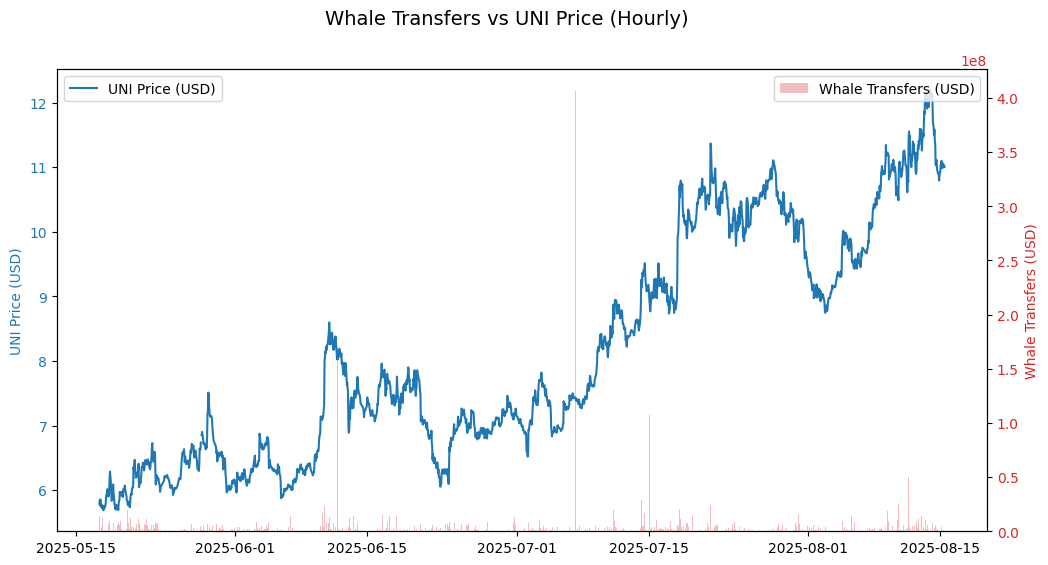

In [121]:
plot_whales_vs_price(merged)


### Do whale spikes align with price volatility?

Volatility can be measured as the % change over a fixed horizon (say 6h or 24h).

In [123]:
# Calculate rolling volatility (absolute % change over 6h window)
merged["vol_6h"] = merged["price"].pct_change(periods=12, fill_method=None).abs() * 100


# Tag whale spikes: e.g., above 90th percentile of total_amount_usd
threshold = merged["total_amount_usd"].quantile(0.9)
merged["whale_spike"] = merged["total_amount_usd"] > threshold

# Compare volatility on spike vs non-spike hours
vol_spike = merged.loc[merged["whale_spike"], "vol_6h"].mean()
vol_normal = merged.loc[~merged["whale_spike"], "vol_6h"].mean()


print(f"Avg volatility after whale spikes: {vol_spike:.2f}%")
print(f"Avg volatility otherwise: {vol_normal:.2f}%")


Avg volatility after whale spikes: 4.36%
Avg volatility otherwise: 3.02%


In [124]:
# Forward 6h return
merged["fwd_return_6h"] = merged["price"].shift(-6) / merged["price"] - 1

# Correlation
corr_amount = merged["total_amount_usd"].corr(merged["fwd_return_6h"])
corr_txs = merged["whale_txs"].corr(merged["fwd_return_6h"])

print(f"Correlation (whale USD vs 6h return): {corr_amount:.3f}")
print(f"Correlation (whale tx count vs 6h return): {corr_txs:.3f}")


Correlation (whale USD vs 6h return): 0.011
Correlation (whale tx count vs 6h return): 0.056


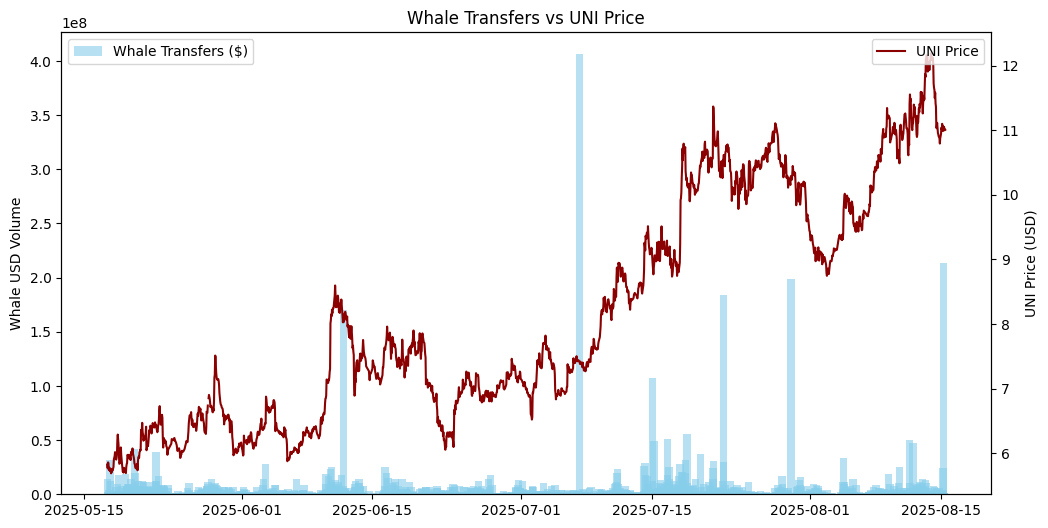

In [125]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12,6))

# Whale USD volume as bars
ax1.bar(merged["block_hour"], merged["total_amount_usd"], 
        color="skyblue", alpha=0.6, label="Whale Transfers ($)")
ax1.set_ylabel("Whale USD Volume")

# Price as line
ax2 = ax1.twinx()
ax2.plot(merged["block_hour"], merged["price"], color="darkred", label="UNI Price")
ax2.set_ylabel("UNI Price (USD)")

# Formatting
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.title("Whale Transfers vs UNI Price")
plt.show()


In [126]:
# Define a whale spike threshold (e.g. > $500k in one hour)
whale_threshold = 500_000  

# Create indicator for whale spike hours
merged["is_whale_spike"] = merged["total_amount_usd"] > whale_threshold


In [127]:
results = {}

for horizon in [1, 3, 6, 12, 24]:
    merged[f"vol_{horizon}h"] = (
        merged["price"].pct_change(periods=horizon, fill_method=None).abs() * 100
    )

    avg_vol_spikes = merged.loc[merged["is_whale_spike"], f"vol_{horizon}h"].mean()
    avg_vol_normal = merged.loc[~merged["is_whale_spike"], f"vol_{horizon}h"].mean()

    results[horizon] = {
        "avg_vol_spikes": avg_vol_spikes,
        "avg_vol_normal": avg_vol_normal,
    }

vol_results = pd.DataFrame(results).T
print(vol_results)


    avg_vol_spikes  avg_vol_normal
1             0.86            0.60
3             1.60            1.15
6             2.36            1.64
12            3.35            2.45
24            4.78            3.78
